<a href="https://colab.research.google.com/github/victorm0202/temas_selectos_CD/blob/main/RNNs_for_Text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Summary

In this example, we will implement a neural network for text classification task. The network consists of 3 layers:

- Embeddings layer
- RNN layer
- Linear layer

The embedding layer has word embeddings for each token/word of our dictionary. We have set an embedding length of 50 for our example. This means that the embedding layer will have the weight of shape (len_vocab, 50). It has an embedding vector of length 50 for each token of our vocabulary. 

The embedding layer simply maps input indexes to a list of embeddings. Our data loaders will be returning indexes for tokens of text examples which will be given to the embedding layer as input which will convert indexes to embeddings. These embeddings will be updated during training to better classify documents. The input of the embedding layer will be of shape (batch_size, `max_words`) and the output will be (batch_size, `max_words`, 50), The batch size in our case is 1024. Further details of `max_words` parameter is given later in the example. 

# The imports 

In [1]:
!pip install torchdata

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 15.5 MB/s 
     |████████████████████████████████| 140 kB 58.0 MB/s 
     |████████████████████████████████| 127 kB 64.3 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [2]:
import torch
import torchtext

#print("PyTorch Version : {}".format(torch.__version__))
#print("Torch Text Version : {}".format(torchtext.__version__))

# The dataset

We will use AG NEWS dataset available from torchtext library. It has text documents for 4 different categories `["World", "Sports", "Business", "Sci/Tech"]`. The dataset is already divided into train and test sets.

In [3]:
from torch.utils.data import DataLoader
train_dataset, test_dataset  = torchtext.datasets.AG_NEWS()
#train_dataset, test_dataset  = torchtext.datasets.YelpReviewFull()

In [4]:
type(train_dataset)

torch.utils.data.datapipes.iter.grouping.ShardingFilterIterDataPipe

## Tokenize Text Data And Build Vocabulary

In [5]:
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer("basic_english") ## We'll use tokenizer available from PyTorch

def build_vocab(datasets):
    for dataset in datasets:
        for _, text in dataset:
            yield tokenizer(text)

vocab = build_vocab_from_iterator(build_vocab([train_dataset, test_dataset]), specials=["<PAD>", "<UNK>"])
vocab.set_default_index(vocab["<UNK>"])

In [6]:
len(vocab)

98636

In [7]:
tokens = tokenizer("Hello how are you?")
indexes = vocab(tokens)

tokens, indexes

(['hello', 'how', 'are', 'you', '?'], [12389, 356, 43, 165, 81])

 # Setting up the device for training

In [8]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


# Data Loaders (Vectorize Text Data)

We have decided to keep a maximum of `max_words` words per document. To handle that condition, we have truncated words from documents that have more than `max_words` words and padded documents (with zeros) to documents that have less than `max_words` words. The number of words to keep per document is one of the hyperparameters to train. 

In [12]:
from torch.utils.data import DataLoader
from torchtext.data.functional import to_map_style_dataset

max_words = 25

train_dataset, test_dataset  = torchtext.datasets.AG_NEWS()
train_dataset, test_dataset = to_map_style_dataset(train_dataset), to_map_style_dataset(test_dataset)
target_classes = ["World", "Sports", "Business", "Sci/Tech"]

def vectorize_batch(batch):
    Y, X = list(zip(*batch))
    X = [vocab(tokenizer(sample)) for sample in X]
    ## Bringing all samples to max_words length.
    X = [sample+([0]* (max_words-len(sample))) if len(sample)<max_words else sample[:max_words] for sample in X] 
    ## We have deducted 1 from target names to get them in range [0,1,2,3,5] from [1,2,3,4,5]
    return torch.tensor(X, dtype=torch.int32).to(device), torch.tensor(Y).to(device) - 1 


We will create train and test data loaders that return a batch of 1024 examples and their respective target labels for each call. The function `vectorize_batch()` will be used to vectorize text examples of a batch of data. For each batch, it'll tokenize text examples using a tokenizer, generates indexes using vocabulary, and return indexes as torch tensors along with target labels.

In [13]:
train_loader = DataLoader(train_dataset, batch_size=1024, collate_fn=vectorize_batch)
test_loader  = DataLoader(test_dataset, batch_size=1024, collate_fn=vectorize_batch)

In [14]:
len(train_dataset)

120000

In [11]:
for X, Y in train_loader:
    print(X.shape, Y.shape)
    break

torch.Size([1024, 25]) torch.Size([1024])


# RNN architecture

The RNN layer will take input from embedding layer of shape (batch_size, max_tokens, embedding_length) = (batch_size, `max_words`, 50), perform it's operations and return an output of shape (batch_size, max_tokens, hidden_size) = (batch_size, `max_words`, 50). In our case, the output shape of RNN layer is 50. If for example the hidden size of a recurrent layer is set at 75 then output from the recurrent layer will be of shape (batch_size, `max_words`, 75). The recurrent layer loops through embeddings of tokens for each text example and generates output that has some knowledge about the context of the text documents. When calling the recurrent layer in the forward pass, we need to provide initial state detail to it which we have provided as random numbers. An initial state is needed for each text example. If we don't provide it then PyTorch generates a tensor of zeros internally. In our case, we have provided random numbers of shape (1, batch_size, 50) which means for each text example we have provided a real-valued vector of length 50 as an initial state. We recommend that the reader goes through this link if he/she wants to know how RNN layer works internally. Basically, it takes embedding for a single token and the initial state as input and returns the output. This output will become the state for the next token for the text example. For the next token, it'll again take embedding & state (previous output) and returns the new output (state). This process goes till the last token of the text example. This loop is repeated for each text example (`max_words` tokens).

We can create recurrent layer using RNN() constructor available from 'nn' sub-module of torch library. We need to provide input shape and hidden dimension size to the constructor. We can create multiple RNN layers by providing an integer value greater than 1 to num_layers parameter. By default, the output shape of RNN layer will be (`max_words`, batch_size, 50) but we have converted it to (batch_size, `max_words`, 50) by setting batch_first parameter to True.

The output of RNN will be given to the linear layer which has 4 output units (same as a number of target classes). We have given the last output of each example (output[:,-1]) in our case to the linear layer because the RNN layer generates output for each `max_words` tokens of the text example. We only need to give the last output of each example to be given as input to the linear layer as according to the concept of RNN, it has information about all previous tokens. So, even though the output of RNN layer is of shape (batch_size, `max_words`, 50), the input to the linear layer will be (batch_size, 50) because we'll take the last entry from `max_words` entries for each example.

In [52]:
from torch import nn
from torch.nn import functional as F

embed_len = 50
hidden_dim = 50
n_layers=1

class RNNClassifier(nn.Module):
    def __init__(self):
        super(RNNClassifier, self).__init__()
        self.embedding_layer = nn.Embedding(num_embeddings=len(vocab), embedding_dim=embed_len)
        self.rnn = nn.RNN(input_size=embed_len, hidden_size=hidden_dim, num_layers=n_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, len(target_classes))

    def forward(self, X_batch):
        embeddings = self.embedding_layer(X_batch)
        embedding = embeddings.to(device)
        output, hidden = self.rnn(embeddings, torch.randn(n_layers, len(X_batch), hidden_dim).to(device))
        return self.linear(output[:,-1])

After defining the network, we initialized it, printed the shape of weights/biases of layers, and performed a forward pass to make predictions as well. These steps were done for verification purposes that the network works as expected.

In [53]:
rnn_classifier = RNNClassifier()
rnn_classifier.to(device)
rnn_classifier

RNNClassifier(
  (embedding_layer): Embedding(98636, 50)
  (rnn): RNN(50, 50, batch_first=True)
  (linear): Linear(in_features=50, out_features=4, bias=True)
)

In [54]:
for layer in rnn_classifier.children():
    print("Layer : {}".format(layer))
    print("Parameters : ")
    for param in layer.parameters():
        print(param.shape)
    print()

Layer : Embedding(98636, 50)
Parameters : 
torch.Size([98636, 50])

Layer : RNN(50, 50, batch_first=True)
Parameters : 
torch.Size([50, 50])
torch.Size([50, 50])
torch.Size([50])
torch.Size([50])

Layer : Linear(in_features=50, out_features=4, bias=True)
Parameters : 
torch.Size([4, 50])
torch.Size([4])



In [55]:
temp = torch.randint(0, len(vocab), (1024, max_words)).to(device)
out = rnn_classifier(temp)
out.shape

torch.Size([1024, 4])

## Training and evaluate the model

In [56]:
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import accuracy_score
import gc

def CalcValLossAndAccuracy(model, loss_fn, val_loader):
    with torch.no_grad():
        Y_shuffled, Y_preds, losses = [],[],[]
        for X, Y in tqdm(val_loader):
            X = X.to(device)
            Y = Y.to(device)
            preds = model(X)
            loss = loss_fn(preds, Y)
            losses.append(loss.item())

            Y_shuffled.append(Y)
            Y_preds.append(preds.argmax(dim=-1))

        Y_shuffled = torch.cat(Y_shuffled)
        Y_preds = torch.cat(Y_preds)

        print("Valid Loss : {:.3f}".format(torch.tensor(losses).mean()))
        print("Valid Acc  : {:.3f}".format(accuracy_score(Y_shuffled.detach().cpu().numpy(), Y_preds.detach().cpu().numpy())))


def TrainModel(model, loss_fn, optimizer, train_loader, val_loader, epochs=10):
    for i in range(1, epochs+1):
        losses = []
        for X, Y in tqdm(train_loader):
            X = X.to(device)
            Y = Y.to(device)
            Y_preds = model(X)

            loss = loss_fn(Y_preds, Y)
            losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print("Train Loss : {:.3f}".format(torch.tensor(losses).mean()))
        CalcValLossAndAccuracy(model, loss_fn, val_loader)


In [57]:
from torch.optim import Adam

epochs = 15
learning_rate = 1e-3

loss_fn = nn.CrossEntropyLoss()
rnn_classifier = RNNClassifier()
# Send model to `device` (GPU/CPU)
rnn_classifier.to(device)
optimizer = Adam(rnn_classifier.parameters(), lr=learning_rate)

TrainModel(rnn_classifier, loss_fn, optimizer, train_loader, test_loader, epochs)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]

Train Loss : 1.329


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/8 [00:00<?, ?it/s]

Valid Loss : 1.179
Valid Acc  : 0.491


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]

Train Loss : 1.021


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/8 [00:00<?, ?it/s]

Valid Loss : 0.878
Valid Acc  : 0.653


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]

Train Loss : 0.755


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/8 [00:00<?, ?it/s]

Valid Loss : 0.694
Valid Acc  : 0.745


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]

Train Loss : 0.606


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/8 [00:00<?, ?it/s]

Valid Loss : 0.607
Valid Acc  : 0.783


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]

Train Loss : 0.516


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/8 [00:00<?, ?it/s]

Valid Loss : 0.544
Valid Acc  : 0.807


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]

Train Loss : 0.456


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/8 [00:00<?, ?it/s]

Valid Loss : 0.515
Valid Acc  : 0.823


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]

Train Loss : 0.412


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/8 [00:00<?, ?it/s]

Valid Loss : 0.489
Valid Acc  : 0.832


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]

Train Loss : 0.378


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/8 [00:00<?, ?it/s]

Valid Loss : 0.469
Valid Acc  : 0.845


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]

Train Loss : 0.348


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/8 [00:00<?, ?it/s]

Valid Loss : 0.463
Valid Acc  : 0.851


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]

Train Loss : 0.324


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/8 [00:00<?, ?it/s]

Valid Loss : 0.446
Valid Acc  : 0.856


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]

Train Loss : 0.304


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/8 [00:00<?, ?it/s]

Valid Loss : 0.437
Valid Acc  : 0.858


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]

Train Loss : 0.287


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/8 [00:00<?, ?it/s]

Valid Loss : 0.432
Valid Acc  : 0.861


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]

Train Loss : 0.269


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/8 [00:00<?, ?it/s]

Valid Loss : 0.426
Valid Acc  : 0.866


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]

Train Loss : 0.255


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/8 [00:00<?, ?it/s]

Valid Loss : 0.423
Valid Acc  : 0.869


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]

Train Loss : 0.243


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/8 [00:00<?, ?it/s]

Valid Loss : 0.421
Valid Acc  : 0.868


In [58]:
def MakePredictions(model, loader):
    Y_shuffled, Y_preds = [], []
    for X, Y in loader:
        X = X.to(device)
        Y = Y.to(device)
        preds = model(X)
        Y_preds.append(preds)
        Y_shuffled.append(Y)
    gc.collect()
    Y_preds, Y_shuffled = torch.cat(Y_preds), torch.cat(Y_shuffled)

    return Y_shuffled.detach().cpu().numpy(), F.softmax(Y_preds, dim=-1).argmax(dim=-1).detach().cpu().numpy()

Y_actual, Y_preds = MakePredictions(rnn_classifier, test_loader)

In [59]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Test Accuracy : {}".format(accuracy_score(Y_actual, Y_preds)))
print("\nClassification Report : ")
print(classification_report(Y_actual, Y_preds, target_names=target_classes))
print("\nConfusion Matrix : ")
print(confusion_matrix(Y_actual, Y_preds))

Test Accuracy : 0.8646052631578948

Classification Report : 
              precision    recall  f1-score   support

       World       0.90      0.86      0.88      1900
      Sports       0.92      0.95      0.93      1900
    Business       0.79      0.87      0.83      1900
    Sci/Tech       0.86      0.78      0.82      1900

    accuracy                           0.86      7600
   macro avg       0.87      0.86      0.86      7600
weighted avg       0.87      0.86      0.86      7600


Confusion Matrix : 
[[1626   60  120   94]
 [  49 1809   25   17]
 [  62   54 1646  138]
 [  78   49  283 1490]]


In [ ]:
!pip install scikit-plot

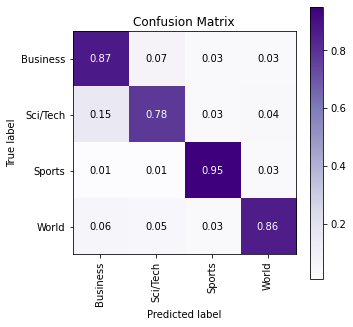

In [62]:
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
import matplotlib.pyplot as plt
import numpy as np

skplt.metrics.plot_confusion_matrix([target_classes[i] for i in Y_actual], [target_classes[i] for i in Y_preds],
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="Purples",
                                    hide_zeros=True,
                                    figsize=(5,5)
                                    );
plt.xticks(rotation=90);

## Explain Network Predictions Using LIME Algorithm

LIME (Local Interpretable Model-Agnostic Explanations) [link](https://lime-ml.readthedocs.io/en/latest/) [github](https://github.com/marcotcr/lime) let us generate a visualization that highlights words that contributed to prediction.

In order to explain prediction using lime, we first need to create an instance of LimeTextExplainer using the constructor available from lime_text sub-module of lime. Then, we need to call explain_instance() method on LimeTextExplainer instance to generate Explanation instance. At last, we need to call show_in_notebook() method on Explanation instance to generate a visualization that shows words from the text which contributed to predicting a particular target label.

Below, we have first retrieved all text examples from the test dataset. Then, we have created an instance of LimeTextExplainer with our target labels. Then, we have defined a function that will be required by explain_instance() method. The function takes as an input list of text examples and returns prediction probabilities for them. The function tokenizes and vectorizes data before giving it to the network for making predictions. The output of the network is converted to probabilities using softmax activation function and returned from the function.

After defining a function, we randomly selected on text example from the test dataset and made predictions on it using our trained network. We have then printed the actual and predicted labels for the selected sample. We can notice that our model correctly predicts the category as 'Business'.

In [ ]:
!pip install lime

In [66]:
X_test_text, Y_test = [], []
for Y, X in test_dataset:
    X_test_text.append(X)
    Y_test.append(Y-1)

len(X_test_text)

7600

In [67]:
from lime import lime_text
import numpy as np

explainer = lime_text.LimeTextExplainer(class_names=target_classes, verbose=True)

def make_predictions(X_batch_text):
    X = [vocab(tokenizer(text)) for text in X_batch_text]
    X = [tokens+([0]* (max_words-len(tokens))) if len(tokens)<max_words else tokens[:max_words] for tokens in X] ## Bringing all samples to max_words length.
    logits = rnn_classifier(torch.tensor(X, dtype=torch.int32).to(device))
    preds = F.softmax(logits, dim=-1)
    return preds.detach().cpu().numpy()

rng = np.random.RandomState(1)
idx = rng.randint(1, len(X_test_text))
X = [vocab(tokenizer(text)) for text in X_test_text[idx:idx+1]]
X = [tokens+([0]* (max_words-len(tokens))) if len(tokens)<max_words else tokens[:max_words] for tokens in X] ## Bringing all samples to max_words length.
preds = rnn_classifier(torch.tensor(X, dtype=torch.int32).to(device))
preds = F.softmax(preds, dim=-1)

print("Prediction : ", target_classes[preds.argmax()])
print("Actual :     ", target_classes[Y_test[idx]])

Prediction :  Business
Actual :      Business


In [68]:
explanation = explainer.explain_instance(X_test_text[idx], classifier_fn=make_predictions,labels=Y_test[idx:idx+1])
explanation.show_in_notebook()

Intercept 0.7479831825969362
Prediction_local [1.0237973]
Right: 0.9904377


# Stacked RNN architecture

Tokens Per Text Example=50, Embeddings Length=50

In [69]:
max_words = 50
train_loader = DataLoader(train_dataset, batch_size=1024, collate_fn=vectorize_batch, shuffle=True)
test_loader  = DataLoader(test_dataset , batch_size=1024, collate_fn=vectorize_batch)

In [70]:
for X, Y in train_loader:
    print(X.shape, Y.shape)
    break

torch.Size([1024, 50]) torch.Size([1024])


In [72]:
embed_len = 50
hidden_dim = 50
n_layers=3

class RNNClassifier(nn.Module):
    def __init__(self):
        super(RNNClassifier, self).__init__()
        self.embedding_layer = nn.Embedding(num_embeddings=len(vocab), embedding_dim=embed_len)
        self.rnn = nn.RNN(input_size=embed_len, hidden_size=hidden_dim, num_layers=n_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, len(target_classes))

    def forward(self, X_batch):
        embeddings = self.embedding_layer(X_batch)
        embedding = embeddings.to(device)
        output, hidden = self.rnn(embeddings, torch.randn(n_layers, len(X_batch), hidden_dim).to(device))
        return self.linear(output[:,-1])

In [73]:
rnn_classifier = RNNClassifier()
rnn_classifier.to(device)
rnn_classifier

RNNClassifier(
  (embedding_layer): Embedding(98636, 50)
  (rnn): RNN(50, 50, num_layers=3, batch_first=True)
  (linear): Linear(in_features=50, out_features=4, bias=True)
)

In [74]:
for layer in rnn_classifier.children():
    print("Layer : {}".format(layer))
    print("Parameters : ")
    for param in layer.parameters():
        print(param.shape)
    print()

Layer : Embedding(98636, 50)
Parameters : 
torch.Size([98636, 50])

Layer : RNN(50, 50, num_layers=3, batch_first=True)
Parameters : 
torch.Size([50, 50])
torch.Size([50, 50])
torch.Size([50])
torch.Size([50])
torch.Size([50, 50])
torch.Size([50, 50])
torch.Size([50])
torch.Size([50])
torch.Size([50, 50])
torch.Size([50, 50])
torch.Size([50])
torch.Size([50])

Layer : Linear(in_features=50, out_features=4, bias=True)
Parameters : 
torch.Size([4, 50])
torch.Size([4])



In [75]:
temp = torch.randint(0, len(vocab), (1024, max_words)).to(device)
out = rnn_classifier(temp)
out.shape

torch.Size([1024, 4])

## Training and evaluate the model

In [76]:
from torch.optim import Adam

epochs = 15
learning_rate = 1e-3

loss_fn = nn.CrossEntropyLoss()
rnn_classifier = RNNClassifier()
# Send model to `device` (GPU/CPU)
rnn_classifier.to(device)
optimizer = Adam(rnn_classifier.parameters(), lr=learning_rate)

TrainModel(rnn_classifier, loss_fn, optimizer, train_loader, test_loader, epochs)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]

Train Loss : 1.347


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/8 [00:00<?, ?it/s]

Valid Loss : 1.244
Valid Acc  : 0.421


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]

Train Loss : 1.078


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/8 [00:00<?, ?it/s]

Valid Loss : 0.969
Valid Acc  : 0.567


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]

Train Loss : 0.855


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/8 [00:00<?, ?it/s]

Valid Loss : 0.843
Valid Acc  : 0.660


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]

Train Loss : 0.712


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/8 [00:00<?, ?it/s]

Valid Loss : 0.666
Valid Acc  : 0.765


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]

Train Loss : 0.576


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/8 [00:00<?, ?it/s]

Valid Loss : 0.567
Valid Acc  : 0.803


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]

Train Loss : 0.471


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/8 [00:00<?, ?it/s]

Valid Loss : 0.494
Valid Acc  : 0.830


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]

Train Loss : 0.408


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/8 [00:00<?, ?it/s]

Valid Loss : 0.447
Valid Acc  : 0.848


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]

Train Loss : 0.365


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/8 [00:00<?, ?it/s]

Valid Loss : 0.447
Valid Acc  : 0.851


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]

Train Loss : 0.336


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/8 [00:00<?, ?it/s]

Valid Loss : 0.409
Valid Acc  : 0.859


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]

Train Loss : 0.314


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/8 [00:00<?, ?it/s]

Valid Loss : 0.399
Valid Acc  : 0.867


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]

Train Loss : 0.295


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/8 [00:00<?, ?it/s]

Valid Loss : 0.393
Valid Acc  : 0.871


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]

Train Loss : 0.275


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/8 [00:00<?, ?it/s]

Valid Loss : 0.413
Valid Acc  : 0.868


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]

Train Loss : 0.262


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/8 [00:00<?, ?it/s]

Valid Loss : 0.403
Valid Acc  : 0.870


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]

Train Loss : 0.249


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/8 [00:00<?, ?it/s]

Valid Loss : 0.367
Valid Acc  : 0.877


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]

Train Loss : 0.232


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/8 [00:00<?, ?it/s]

Valid Loss : 0.372
Valid Acc  : 0.880


In [77]:
Y_actual, Y_preds = MakePredictions(rnn_classifier, test_loader)

print("Test Accuracy : {}".format(accuracy_score(Y_actual, Y_preds)))
print("\nClassification Report : ")
print(classification_report(Y_actual, Y_preds, target_names=target_classes))
print("\nConfusion Matrix : ")
print(confusion_matrix(Y_actual, Y_preds))

Test Accuracy : 0.8792105263157894

Classification Report : 
              precision    recall  f1-score   support

       World       0.90      0.87      0.88      1900
      Sports       0.94      0.95      0.95      1900
    Business       0.84      0.84      0.84      1900
    Sci/Tech       0.84      0.86      0.85      1900

    accuracy                           0.88      7600
   macro avg       0.88      0.88      0.88      7600
weighted avg       0.88      0.88      0.88      7600


Confusion Matrix : 
[[1647   63  126   64]
 [  36 1809    6   49]
 [  87    8 1601  204]
 [  63   47  165 1625]]


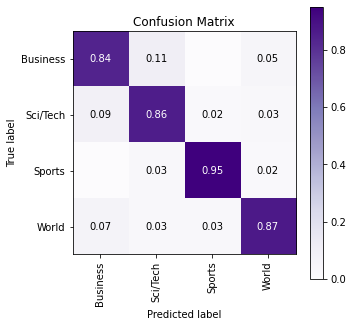

In [78]:
skplt.metrics.plot_confusion_matrix([target_classes[i] for i in Y_actual], [target_classes[i] for i in Y_preds],
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="Purples",
                                    hide_zeros=True,
                                    figsize=(5,5)
                                    );
plt.xticks(rotation=90);

## Explain Network Predictions Using LIME Algorithm

In [79]:
explainer = lime_text.LimeTextExplainer(class_names=target_classes, verbose=True)

def make_predictions(X_batch_text):
    X = [vocab(tokenizer(text)) for text in X_batch_text]
    X = [tokens+([0]* (max_words-len(tokens))) if len(tokens)<max_words else tokens[:max_words] for tokens in X] ## Bringing all samples to max_words length.
    logits = rnn_classifier(torch.tensor(X, dtype=torch.int32).to(device))
    preds = F.softmax(logits, dim=-1)
    return preds.detach().cpu().numpy()

rng = np.random.RandomState(1)
idx = rng.randint(1, len(X_test_text))
X = [vocab(tokenizer(text)) for text in X_test_text[idx:idx+1]]
X = [tokens+([0]* (max_words-len(tokens))) if len(tokens)<max_words else tokens[:max_words] for tokens in X] ## Bringing all samples to max_words length.
preds = rnn_classifier(torch.tensor(X, dtype=torch.int32).to(device))
preds = F.softmax(preds, dim=-1)

print("Prediction : ", target_classes[preds.argmax()])
print("Actual :     ", target_classes[Y_test[idx]])

Prediction :  Business
Actual :      Business


In [80]:
explanation = explainer.explain_instance(X_test_text[idx], classifier_fn=make_predictions,labels=Y_test[idx:idx+1])
explanation.show_in_notebook()


Intercept 0.2686889306904242
Prediction_local [1.02638034]
Right: 0.9599114


# LSTM architecture

Tokens Per Text Example=50, Embeddings Length=50, LSTM Output=75, 3 LSTM layers

In [81]:
max_words = 50
train_loader = DataLoader(train_dataset, batch_size=1024, collate_fn=vectorize_batch, shuffle=True)
test_loader  = DataLoader(test_dataset , batch_size=1024, collate_fn=vectorize_batch)

In [83]:
embed_len = 50
hidden_dim = 75
n_layers=3

class LSTMClassifier(nn.Module):
    def __init__(self):
        super(LSTMClassifier, self).__init__()
        self.embedding_layer = nn.Embedding(num_embeddings=len(vocab), embedding_dim=embed_len)
        self.lstm = nn.LSTM(input_size=embed_len, hidden_size=hidden_dim, num_layers=n_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, len(target_classes))

    def forward(self, X_batch):
        embeddings = self.embedding_layer(X_batch)
        embeddings = embeddings.to(device)
        hidden, carry = torch.randn(n_layers, len(X_batch), hidden_dim), torch.randn(n_layers, len(X_batch), hidden_dim)
        output, (hidden, carry) = self.lstm(embeddings, (hidden.to(device), carry.to(device)))
        return self.linear(output[:,-1])

In [84]:
lstm_classifier = LSTMClassifier()
lstm_classifier.to(device)
lstm_classifier

LSTMClassifier(
  (embedding_layer): Embedding(98636, 50)
  (lstm): LSTM(50, 75, num_layers=3, batch_first=True)
  (linear): Linear(in_features=75, out_features=4, bias=True)
)

In [85]:
for layer in lstm_classifier.children():
    print("Layer : {}".format(layer))
    print("Parameters : ")
    for param in layer.parameters():
        print(param.shape)
    print()

Layer : Embedding(98636, 50)
Parameters : 
torch.Size([98636, 50])

Layer : LSTM(50, 75, num_layers=3, batch_first=True)
Parameters : 
torch.Size([300, 50])
torch.Size([300, 75])
torch.Size([300])
torch.Size([300])
torch.Size([300, 75])
torch.Size([300, 75])
torch.Size([300])
torch.Size([300])
torch.Size([300, 75])
torch.Size([300, 75])
torch.Size([300])
torch.Size([300])

Layer : Linear(in_features=75, out_features=4, bias=True)
Parameters : 
torch.Size([4, 75])
torch.Size([4])



In [86]:
temp = torch.randint(0, len(vocab), (1024, max_words)).to(device)
out = lstm_classifier(temp)
out.shape

torch.Size([1024, 4])

## Training and evaluate

In [87]:
epochs = 10
learning_rate = 1e-3

loss_fn = nn.CrossEntropyLoss()
lstm_classifier = LSTMClassifier()
lstm_classifier.to(device)
optimizer = Adam(lstm_classifier.parameters(), lr=learning_rate)

TrainModel(lstm_classifier, loss_fn, optimizer, train_loader, test_loader, epochs)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]

Train Loss : 1.242


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/8 [00:00<?, ?it/s]

Valid Loss : 1.019
Valid Acc  : 0.523


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]

Train Loss : 0.807


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/8 [00:00<?, ?it/s]

Valid Loss : 0.659
Valid Acc  : 0.743


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]

Train Loss : 0.506


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/8 [00:00<?, ?it/s]

Valid Loss : 0.477
Valid Acc  : 0.822


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]

Train Loss : 0.396


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/8 [00:00<?, ?it/s]

Valid Loss : 0.420
Valid Acc  : 0.850


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]

Train Loss : 0.341


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/8 [00:00<?, ?it/s]

Valid Loss : 0.391
Valid Acc  : 0.863


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]

Train Loss : 0.299


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/8 [00:00<?, ?it/s]

Valid Loss : 0.362
Valid Acc  : 0.874


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]

Train Loss : 0.267


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/8 [00:00<?, ?it/s]

Valid Loss : 0.350
Valid Acc  : 0.881


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]

Train Loss : 0.241


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/8 [00:00<?, ?it/s]

Valid Loss : 0.338
Valid Acc  : 0.885


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]

Train Loss : 0.221


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/8 [00:00<?, ?it/s]

Valid Loss : 0.335
Valid Acc  : 0.887


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]

Train Loss : 0.203


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/8 [00:00<?, ?it/s]

Valid Loss : 0.342
Valid Acc  : 0.888


In [90]:
Y_actual, Y_preds = MakePredictions(lstm_classifier, test_loader)

print("Test Accuracy : {}".format(accuracy_score(Y_actual, Y_preds)))
print("\nClassification Report : ")
print(classification_report(Y_actual, Y_preds, target_names=target_classes))
print("\nConfusion Matrix : ")
print(confusion_matrix(Y_actual, Y_preds))

Test Accuracy : 0.8864473684210527

Classification Report : 
              precision    recall  f1-score   support

       World       0.86      0.92      0.89      1900
      Sports       0.94      0.96      0.95      1900
    Business       0.87      0.82      0.85      1900
    Sci/Tech       0.87      0.84      0.86      1900

    accuracy                           0.89      7600
   macro avg       0.89      0.89      0.89      7600
weighted avg       0.89      0.89      0.89      7600


Confusion Matrix : 
[[1745   57   58   40]
 [  41 1828    6   25]
 [ 143   18 1560  179]
 [  89   48  159 1604]]


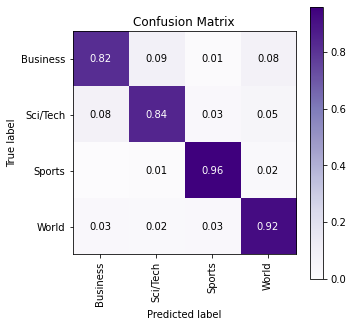

In [91]:
skplt.metrics.plot_confusion_matrix([target_classes[i] for i in Y_actual], [target_classes[i] for i in Y_preds],
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="Purples",
                                    hide_zeros=True,
                                    figsize=(5,5)
                                    );
plt.xticks(rotation=90);

## Explain Network Predictions Using LIME Algorithm

In [92]:
explainer = lime_text.LimeTextExplainer(class_names=target_classes, verbose=True)

def make_predictions(X_batch_text):
    X = [vocab(tokenizer(text)) for text in X_batch_text]
    X = [tokens+([0]* (max_words-len(tokens))) if len(tokens)<max_words else tokens[:max_words] for tokens in X] ## Bringing all samples to max_words length.
    logits = lstm_classifier(torch.tensor(X, dtype=torch.int32).to(device))
    preds = F.softmax(logits, dim=-1)
    return preds.detach().cpu().numpy()

rng = np.random.RandomState(1)
idx = rng.randint(1, len(X_test_text))
X = [vocab(tokenizer(text)) for text in X_test_text[idx:idx+1]]
X = [tokens+([0]* (max_words-len(tokens))) if len(tokens)<max_words else tokens[:max_words] for tokens in X] ## Bringing all samples to max_words length.
preds = lstm_classifier(torch.tensor(X, dtype=torch.int32).to(device))
preds = F.softmax(preds, dim=-1)

print("Prediction : ", target_classes[preds.argmax()])
print("Actual :     ", target_classes[Y_test[idx]])

Prediction :  Business
Actual :      Business


In [93]:
explanation = explainer.explain_instance(X_test_text[idx], classifier_fn=make_predictions,labels=Y_test[idx:idx+1])
explanation.show_in_notebook()

Intercept 0.05236518952941571
Prediction_local [1.02125094]
Right: 0.9644779


# Stacked LSTM architecture with different output sizes.

Tokens Per Text Example=50, Embeddings Length=50, LSTM Output=75, 3 LSTM layers

We will use 3 LSTM layers with different hidden_size: (50, 60, and 75). The output of the embedding layer is given to the first LSTM whose output is given to the second LSTM layer. The output of the second LSTM layer is given to the third LSTM and the output of the last LSTM layer is given to the Linear layer. Please make a NOTE that we have defined hidden and carry for each LSTM layer separately.

In [94]:
max_words = 50
train_loader = DataLoader(train_dataset, batch_size=1024, collate_fn=vectorize_batch, shuffle=True)
test_loader  = DataLoader(test_dataset , batch_size=1024, collate_fn=vectorize_batch)

In [95]:
embed_len = 50
hidden_dim1 = 50
hidden_dim2 = 60
hidden_dim3 = 75
n_layers=1

class LSTMClassifier(nn.Module):
    def __init__(self):
        super(LSTMClassifier, self).__init__()
        self.embedding_layer = nn.Embedding(num_embeddings=len(vocab), embedding_dim=embed_len)
        self.lstm1 = nn.LSTM(input_size=embed_len, hidden_size=hidden_dim1, num_layers=1, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=hidden_dim1, hidden_size=hidden_dim2, num_layers=1, batch_first=True)
        self.lstm3 = nn.LSTM(input_size=hidden_dim2, hidden_size=hidden_dim3, num_layers=1, batch_first=True)
        self.linear = nn.Linear(hidden_dim3, len(target_classes))

    def forward(self, X_batch):
        embeddings = self.embedding_layer(X_batch)
        embeddings = embeddings.to(device)
        hidden, carry = torch.randn(n_layers, len(X_batch), hidden_dim1), torch.randn(n_layers, len(X_batch), hidden_dim1)
        output, (hidden, carry) = self.lstm1(embeddings, (hidden.to(device), carry.to(device)))

        hidden, carry = torch.randn(n_layers, len(X_batch), hidden_dim2), torch.randn(n_layers, len(X_batch), hidden_dim2)
        output, (hidden, carry) = self.lstm2(output, (hidden.to(device), carry.to(device)))

        hidden, carry = torch.randn(n_layers, len(X_batch), hidden_dim3), torch.randn(n_layers, len(X_batch), hidden_dim3)
        output, (hidden, carry) = self.lstm3(output, (hidden.to(device), carry.to(device)))
        return self.linear(output[:,-1])

In [96]:
lstm_classifier = LSTMClassifier()
lstm_classifier.to(device)
lstm_classifier

LSTMClassifier(
  (embedding_layer): Embedding(98636, 50)
  (lstm1): LSTM(50, 50, batch_first=True)
  (lstm2): LSTM(50, 60, batch_first=True)
  (lstm3): LSTM(60, 75, batch_first=True)
  (linear): Linear(in_features=75, out_features=4, bias=True)
)

In [97]:
for layer in lstm_classifier.children():
    print("Layer : {}".format(layer))
    print("Parameters : ")
    for param in layer.parameters():
        print(param.shape)
    print()

Layer : Embedding(98636, 50)
Parameters : 
torch.Size([98636, 50])

Layer : LSTM(50, 50, batch_first=True)
Parameters : 
torch.Size([200, 50])
torch.Size([200, 50])
torch.Size([200])
torch.Size([200])

Layer : LSTM(50, 60, batch_first=True)
Parameters : 
torch.Size([240, 50])
torch.Size([240, 60])
torch.Size([240])
torch.Size([240])

Layer : LSTM(60, 75, batch_first=True)
Parameters : 
torch.Size([300, 60])
torch.Size([300, 75])
torch.Size([300])
torch.Size([300])

Layer : Linear(in_features=75, out_features=4, bias=True)
Parameters : 
torch.Size([4, 75])
torch.Size([4])



In [98]:
temp = torch.randint(0, len(vocab), (1024, max_words)).to(device)
out = lstm_classifier(temp)
out.shape

torch.Size([1024, 4])

## Training and evaluate the model

In [99]:
epochs = 10
learning_rate = 1e-3

loss_fn = nn.CrossEntropyLoss()
lstm_classifier = LSTMClassifier()
lstm_classifier.to(device)
optimizer = Adam(lstm_classifier.parameters(), lr=learning_rate)

TrainModel(lstm_classifier, loss_fn, optimizer, train_loader, test_loader, epochs)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]

Train Loss : 1.257


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/8 [00:00<?, ?it/s]

Valid Loss : 1.029
Valid Acc  : 0.534


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]

Train Loss : 0.843


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/8 [00:00<?, ?it/s]

Valid Loss : 0.739
Valid Acc  : 0.709


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]

Train Loss : 0.561


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/8 [00:00<?, ?it/s]

Valid Loss : 0.551
Valid Acc  : 0.794


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]

Train Loss : 0.416


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/8 [00:00<?, ?it/s]

Valid Loss : 0.440
Valid Acc  : 0.841


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]

Train Loss : 0.348


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/8 [00:00<?, ?it/s]

Valid Loss : 0.401
Valid Acc  : 0.859


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]

Train Loss : 0.304


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/8 [00:00<?, ?it/s]

Valid Loss : 0.379
Valid Acc  : 0.869


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]

Train Loss : 0.273


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/8 [00:00<?, ?it/s]

Valid Loss : 0.351
Valid Acc  : 0.879


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]

Train Loss : 0.247


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/8 [00:00<?, ?it/s]

Valid Loss : 0.339
Valid Acc  : 0.883


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]

Train Loss : 0.224


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/8 [00:00<?, ?it/s]

Valid Loss : 0.326
Valid Acc  : 0.889


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]

Train Loss : 0.207


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/8 [00:00<?, ?it/s]

Valid Loss : 0.326
Valid Acc  : 0.891


In [100]:
Y_actual, Y_preds = MakePredictions(lstm_classifier, test_loader)

print("Test Accuracy : {}".format(accuracy_score(Y_actual, Y_preds)))
print("\nClassification Report : ")
print(classification_report(Y_actual, Y_preds, target_names=target_classes))
print("\nConfusion Matrix : ")
print(confusion_matrix(Y_actual, Y_preds))

Test Accuracy : 0.8919736842105264

Classification Report : 
              precision    recall  f1-score   support

       World       0.91      0.89      0.90      1900
      Sports       0.93      0.96      0.95      1900
    Business       0.89      0.82      0.86      1900
    Sci/Tech       0.83      0.89      0.86      1900

    accuracy                           0.89      7600
   macro avg       0.89      0.89      0.89      7600
weighted avg       0.89      0.89      0.89      7600


Confusion Matrix : 
[[1687   67   77   69]
 [  35 1830   11   24]
 [  65   24 1563  248]
 [  62   39  100 1699]]


(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

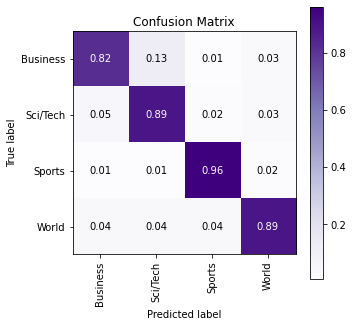

In [101]:
skplt.metrics.plot_confusion_matrix([target_classes[i] for i in Y_actual], [target_classes[i] for i in Y_preds],
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="Purples",
                                    hide_zeros=True,
                                    figsize=(5,5)
                                    );
plt.xticks(rotation=90)

## Explain Network Predictions Using LIME Algorithm

In [102]:
explainer = lime_text.LimeTextExplainer(class_names=target_classes, verbose=True)

def make_predictions(X_batch_text):
    X = [vocab(tokenizer(text)) for text in X_batch_text]
    X = [tokens+([0]* (max_words-len(tokens))) if len(tokens)<max_words else tokens[:max_words] for tokens in X] ## Bringing all samples to max_words length.
    logits = lstm_classifier(torch.tensor(X, dtype=torch.int32).to(device))
    preds = F.softmax(logits, dim=-1)
    return preds.detach().cpu().numpy()

rng = np.random.RandomState(1)
idx = rng.randint(1, len(X_test_text))
X = [vocab(tokenizer(text)) for text in X_test_text[idx:idx+1]]
X = [tokens+([0]* (max_words-len(tokens))) if len(tokens)<max_words else tokens[:max_words] for tokens in X] ## Bringing all samples to max_words length.
preds = lstm_classifier(torch.tensor(X, dtype=torch.int32).to(device))
preds = F.softmax(preds, dim=-1)

print("Prediction : ", target_classes[preds.argmax()])
print("Actual :     ", target_classes[Y_test[idx]])

Prediction :  Business
Actual :      Business


In [103]:
explanation = explainer.explain_instance(X_test_text[idx], classifier_fn=make_predictions,labels=Y_test[idx:idx+1])
explanation.show_in_notebook()

Intercept 0.33904971507225146
Prediction_local [1.08667599]
Right: 0.9895259
